In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [8]:
sm.set_framework('tf.keras')

## Data Loading and Manipulating:

In [9]:
# Making a function to load the data:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [10]:
image_dataset = data_loader('night_ride_dataset/Images/') # Normal Images

In [11]:
mask_dataset = data_loader('night_ride_dataset/Masked_Images/') # Masked Images

In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [14]:
mask_dataset.shape

(200, 128, 128, 3)

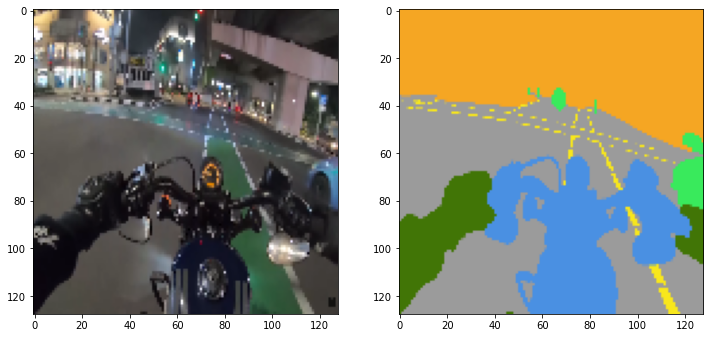

In [35]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()
# Just checking if data is loaded properly or not.

In [207]:
mask_labels = pd.read_csv('night_ride_dataset/class_dict.csv') # mask labels RGB values...

In [208]:
mask_labels

,name,r,g,b
0,bike,74,144,226
1,rider,65,117,6
2,road,155,155,155
3,lanemark,248,231,28
4,movable,57,234,92
5,undrivable,245,166,35


In [209]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [210]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [211]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...
print(np.unique(labels))

[0 1 2 3 4 5]


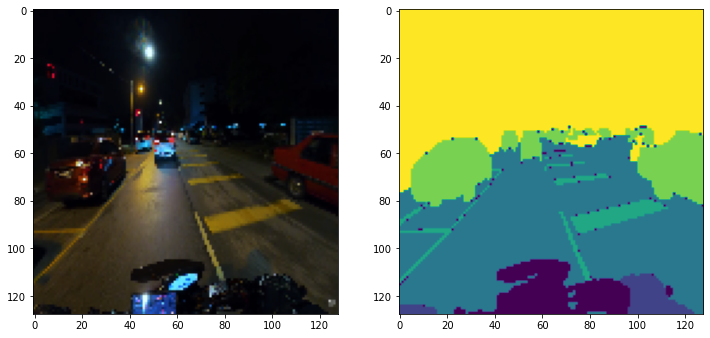

In [212]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [213]:
n_classes = len(np.unique(labels)) # 7 Classes
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels

In [214]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.25, random_state = 42)
# train test splitting.

## Modelling:
We are using resnet pre-trained model to set the initial weights of the UNet. Below is the architecture of the Resnet34:
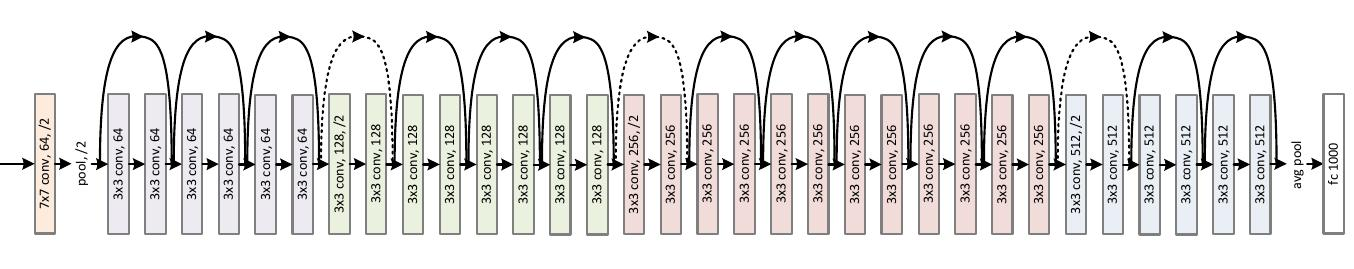

In [215]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)
# Using weights from pretrained resnet model

In [216]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

We are using UNet architecture to train our model for semantic segmentation, below is the architecture of UNet:
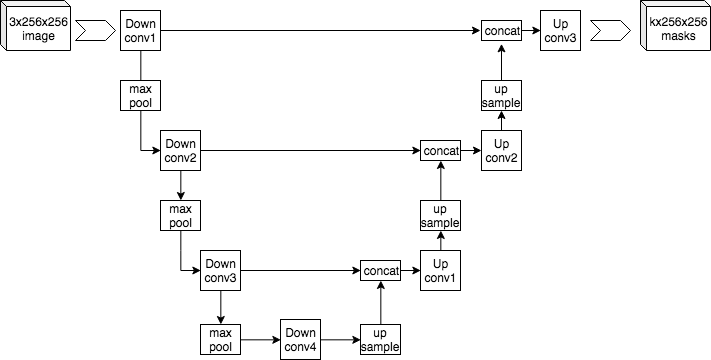

In [217]:
# defining model:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [218]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [219]:
model_resnet_backbone.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_17[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_40 (ZeroPadding  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 2D)                            64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_19[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_20[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_46 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_23 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_23[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_52 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_26[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_58 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_29[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_64 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [221]:
# training the model for 100 epochs with batch size of 16:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
10/10 [==============================] - 31s 3s/step - loss: 0.3956 - accuracy: 0.8649 - val_loss: 1.4989 - val_accuracy: 0.6094
Epoch 2/100
10/10 [==============================] - 34s 3s/step - loss: 0.3607 - accuracy: 0.8836 - val_loss: 1.3426 - val_accuracy: 0.6293
Epoch 3/100
10/10 [==============================] - 31s 3s/step - loss: 0.3253 - accuracy: 0.8963 - val_loss: 1.1118 - val_accuracy: 0.6647
Epoch 4/100
10/10 [==============================] - 30s 3s/step - loss: 0.3069 - accuracy: 0.9014 - val_loss: 0.8417 - val_accuracy: 0.7282
Epoch 5/100
10/10 [==============================] - 30s 3s/step - loss: 0.2829 - accuracy: 0.9077 - val_loss: 0.8915 - val_accuracy: 0.6918
Epoch 6/100
10/10 [==============================] - 31s 3s/step - loss: 0.2570 - accuracy: 0.9173 - val_loss: 0.7989 - val_accuracy: 0.7180
Epoch 7/100
10/10 [==============================] - 30s 3s/step - loss: 0.2395 - accuracy: 0.9222 - val_loss: 0.7596 - val_accuracy: 0.7275
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 30s 3s/step - loss: 0.0748 - accuracy: 0.9736 - val_loss: 0.3599 - val_accuracy: 0.9083
Epoch 60/100
10/10 [==============================] - 30s 3s/step - loss: 0.0749 - accuracy: 0.9735 - val_loss: 0.3496 - val_accuracy: 0.9114
Epoch 61/100
10/10 [==============================] - 30s 3s/step - loss: 0.0755 - accuracy: 0.9732 - val_loss: 0.3637 - val_accuracy: 0.9087
Epoch 62/100
10/10 [==============================] - 30s 3s/step - loss: 0.0734 - accuracy: 0.9741 - val_loss: 0.3686 - val_accuracy: 0.9113
Epoch 63/100
10/10 [==============================] - 30s 3s/step - loss: 0.0775 - accuracy: 0.9722 - val_loss: 0.3597 - val_accuracy: 0.9106
Epoch 64/100
10/10 [==============================] - 30s 3s/step - loss: 0.0743 - accuracy: 0.9737 - val_loss: 0.3734 - val_accuracy: 0.9106
Epoch 65/100
10/10 [==============================] - 30s 3s/step - loss: 0.0724 - accuracy: 0.9744 - val_loss: 0.3712 - val_accuracy: 0.9111
Epoch 

## Testing:

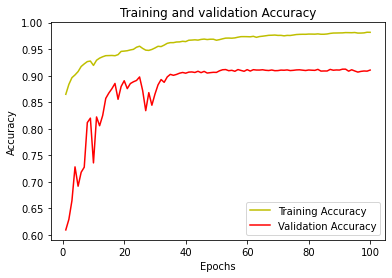

In [222]:
# plotting train and val accuracy:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Saving the Model:

In [223]:
model_resnet_backbone.save('models/resnet_backbone.hdf5')

In [224]:
# Loading our saved model:
model = load_model('models/resnet_backbone.hdf5')

In [225]:
# making predictions:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

2/2 [==============================] - 2s 521ms/step


In [261]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 69ms/step


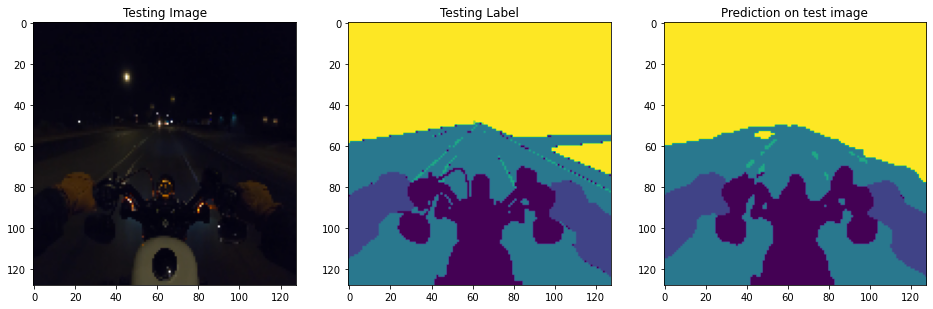

In [262]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()